In [ ]:
import numpy as np
import os, gc, cv2, shutil,platform

import tensorflow as tf
import keras.backend as K
import tensorflow_addons as tfa
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from skimage.feature import local_binary_pattern

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose,Dropout, concatenate, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
#import seaborn as sns
import pandas as pd


from tensorflow_addons.layers import InstanceNormalization, GroupNormalization, SpatialPyramidPooling2D
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from sklearn.model_selection import train_test_split

import keras, gzip, pickle
from keras.layers import *
from keras.optimizers import *
from keras.models import Model, load_model
from keras.callbacks import *
from sklearn.preprocessing import OneHotEncoder


from sklearn.utils import shuffle


physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import util as ul
from model.LBC import LBC
from model.attention_module import attach_attention_module

In [3]:
def check_folder(path):
    if not os.path.isdir(path):
        os.makedirs(path)

In [4]:
def grayToBGR(src_gray, src):
    # RGB在opencv中存储为BGR的顺序,数据结构为一个3D的numpy.array,索引的顺序是行,列,通道:
    B = src[:,:,0]
    G = src[:,:,1]
    R = src[:,:,2]
    # 灰度g=p*R+q*G+t*B（其中p=0.2989,q=0.5870,t=0.1140），于是B=(g-p*R-q*G)/t。于是我们只要保留R和G两个颜色分量，再加上灰度图g，就可以回复原来的RGB图像。
    g = src_gray[:]
    p = 0.2989; q = 0.5870; t = 0.1140
    B_new = (g-p*R-q*G)/t
    B_new = np.uint8(B_new)
    src_new = np.zeros((src.shape)).astype("uint8")
    src_new[:,:,0] = B_new
    src_new[:,:,1] = G
    src_new[:,:,2] = R
    
    return src_new


In [5]:
import glob
from PIL import Image

for filename in glob.glob(r'./data/******/datasets/train/*/*.bmp'):
    img=Image.open(filename).convert("RGB")
    img.save(filename)#原地保存


In [6]:
def generatorDefect2(image, gen_type=1):
    detect_w, detect_h, detect_c = image.shape
    defect_data = copy.deepcopy(image)
    defect_label = np.zeros((detect_w, detect_h), dtype=np.uint8)  # 返回与图像 img1 尺寸相同的全零数组
      
#     mean_r_image = int(np.mean(image[:,:, 0]))
#     mean_g_image = int(np.mean(image[:,:, 1]))
#     mean_p_image = int(np.mean(image[:,:, 2]))
    
#     if LBP_state or Gabor_state:
#         defect_value = random.randrange(0, 255)
#     else:
#         defect_value = random.randrange(0, mean_image)
    
    defect_value = (random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255))

    if gen_type == 0:
        # ellipse
        # detection's width height
        ellipse_w = random.randrange(10, 100)
        ellipse_h = random.randrange(10, 60)
        # position center's x,y
        detect_x, detect_y = random.randrange(0, detect_w), random.randrange(0, detect_h)
        # 水平開始向逆時針偏移
        cur_angle = random.randrange(0, 45)
        # 繪製角度由0~180度的
        strat_ellipse = random.randrange(0, 100)
        end_ellipse = random.choice([90, 110, 120, 150, 160, 210])
        

        # 中心座標是detect_x, detect_y (256, 256)，長軸短軸分別是ellipse_w, ellipse_h(70, 30)，由水平開始向逆時針偏移15度，繪製角度由0~180度的實心橢圓
        cv2.ellipse(defect_data, (detect_x, detect_y), (ellipse_w, ellipse_h), cur_angle, strat_ellipse, end_ellipse,
                    defect_value, -1)
        cv2.ellipse(defect_label, (detect_x, detect_y), (ellipse_w, ellipse_h), cur_angle, strat_ellipse, end_ellipse,
                    (1), -1)

    elif gen_type == 1:
        # 畫粗度為7的紅色線
        start_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
        end_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
        defect_width = random.randrange(4, 20)
        cv2.line(defect_data, start_positon, end_positon, defect_value, defect_width)
        cv2.line(defect_label, start_positon, end_positon, (1), defect_width)

    elif gen_type == 2:
        # detection's width height
        detect_w = random.randrange(4, 10)
        detect_h = random.randrange(int(detect_w / 4), int(detect_w * 2))
        # position center's x,y
        detect_x, detect_y = random.randrange(0, detect_w), random.randrange(0, detect_h)
        defect_radio = random.randrange(10, 40)
        cv2.circle(defect_data, (detect_x, detect_y), defect_radio, defect_value, -1)  # -1 表示实心
        cv2.circle(defect_label, (detect_x, detect_y), defect_radio, (1), -1)  # -1 表示实心
        
    elif gen_type == 3:
        start_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
        defect_length = random.randrange(5, 200)
        defect_width = random.randrange(4, 10)
        cv2.line(defect_data, start_positon, (start_positon[0], start_positon[1] + defect_length), defect_value, defect_width)
        cv2.line(defect_label, start_positon, (start_positon[0], start_positon[1] + defect_length), (1), defect_width)
    # imgAddMask1 = cv2.add(defect_data, np.zeros(np.shape(defect_data), dtype=np.uint8), mask=defect_data)  # 提取圆形 ROI
    
        
#     elif gen_type == 4:
#         start_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
#         defect_length = random.randrange(5, 100)
#         defect_width = random.randrange(4, 20)
        
#         Mask1 = np.zeros((detect_w, detect_h), dtype=np.uint8)
        
#         cv2.line(Mask1, start_positon, (start_positon[0] + defect_length, start_positon[1]), defect_value, defect_width)        
        
#         imgAddMask1 = cv2.add(image, np.zeros(np.shape(image), dtype=np.uint8), mask=Mask1)  # 提取圆形 ROI
        
#         img1_bg = cv2.bitwise_and(image, image, mask=imgAddMask1)
        
#         defect_data = cv2.add(image, img1_bg) # 进行融合
        
#         #cv2.line(defect_data, start_positon, (start_positon[0] + defect_length, start_positon[1]), (defect_value), defect_width)
#         cv2.line(defect_label, start_positon, (start_positon[0] + defect_length, start_positon[1]), (1), defect_width)
        
    # imgAddMask1 = cv2.add(defect_data, np.zeros(np.shape(defect_data), dtype=np.uint8), mask=defect_data)  # 提取圆形 ROI    
    
    return defect_data, defect_label

image = cv2.imread('C:/Users/kaka/Desktop/13234.png', 3)
data1, data2 = generatorDefect(img_BGR, 1)

plt.imshow(Mask1)
plt.show()


plt.imshow(data1)


detect_w, detect_h, detect_c = image.shape

defect_data = copy.deepcopy(image)
defect_label = np.zeros((detect_w, detect_h), dtype=np.uint8)  # 返回与图像 img1 尺寸相同的全零数组

defect_value = (random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255))

start_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
defect_length = random.randrange(5, 100)
defect_width = random.randrange(4, 20)

Mask1 = np.zeros((detect_w, detect_h, detect_c), dtype=np.uint8)

cv2.line(Mask1, start_positon, (start_positon[0] + defect_length, start_positon[1]), defect_value, defect_width)        

#Mask1_BGR = cv2.cvtColor(Mask1,cv2.COLOR_GRAY2RGB)

# imgAddMask1 = cv2.add(image, np.zeros((detect_w, detect_h, detect_c), dtype=np.uint8), mask=Mask1)  # 提取圆形 ROI

print(np.unique(Mask1))

# print(Mask1.shape)
plt.imshow(Mask1)
plt.show()


img1_bg = cv2.bitwise_and(image, Mask1)



defect_data = cv2.add(image, img1_bg) # 进行融合

plt.imshow(defect_data)
plt.show()


#cv2.line(defect_data, start_positon, (start_positon[0] + defect_length, start_positon[1]), (defect_value), defect_width)
cv2.line(defect_label, start_positon, (start_positon[0] + defect_length, start_positon[1]), (1), defect_width)


# Get data

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
from skimage.feature import local_binary_pattern


def crop_resize_center_dataset(origin_path, crop_path, resize_path=True, max_number=5000, crop_shape=(500, 500),
                               resize_shape=(256, 256)):
    floders = folder_list
    if not len(folder_list):
        floders = os.listdir(origin_path)
    for folder in floders:
        img_path2 = origin_path + folder
        crop_path2 = crop_path + folder
        if resize_path:
            resize_path2 = resize_path + folder
            check_folder(resize_path2)
        check_folder(crop_path2)

        cur_list = []
        cur_noise_list = []
        # 影像存檔檔名
        count = 1
        for filename in os.listdir(img_path2):
            if 'jp' in filename:  # or 'jpg' in filename):
                # 讀影像
                # print(img_path2 + '/' + filename)
                img = cv2.imread((img_path2 + '/' + filename), cv2.IMREAD_GRAYSCALE)
                cur_shape = img.shape
                x = int(cur_shape[0] / 2 - crop_shape[0] / 2)
                y = int(cur_shape[1] / 2 - crop_shape[1] / 2)
                # 擷取原始影像中800 x 640的部分
                crop_img = img[y:y + crop_shape[0], x:x + crop_shape[1]]
                cv2.imwrite((resize_path2 + '/' + filename), crop_img)
                count += 1
            if count > max_number:
                break

        np.save(f'{crop_path}/{folder}.npy', cur_list)
        # np.save(f'{crop_path}/{folder}_lbp_noise.npy', cur_noise_list)

def check_folder(path):
    if not os.path.isdir(path):
        os.makedirs(path)


def generatorDefect(image, gen_type=1):
    detect_w, detect_h, detect_c = image.shape

    defect_data = copy.deepcopy(image)
    defect_label = np.zeros(np.shape((detect_w, detect_h)), dtype=np.uint8)  # 返回与图像 img1 尺寸相同的全零数组
    
#     mean_r_image = int(np.mean(image[:,:, 0]))
#     mean_g_image = int(np.mean(image[:,:, 1]))
#     mean_p_image = int(np.mean(image[:,:, 2]))
    
#     if LBP_state or Gabor_state:
#         defect_value = random.randrange(0, 255)
#     else:
#         defect_value = random.randrange(0, mean_image)
    
    defect_value = (random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255))

    if gen_type == 0:
        # ellipse
        # detection's width height
        ellipse_w = random.randrange(10, 100)
        ellipse_h = random.randrange(10, 60)
        # position center's x,y
        detect_x, detect_y = random.randrange(0, detect_w), random.randrange(0, detect_h)
        # 水平開始向逆時針偏移
        cur_angle = random.randrange(0, 45)
        # 繪製角度由0~180度的
        strat_ellipse = random.randrange(0, 100)
        end_ellipse = random.choice([90, 110, 120, 150, 160, 210])

        # 中心座標是detect_x, detect_y (256, 256)，長軸短軸分別是ellipse_w, ellipse_h(70, 30)，由水平開始向逆時針偏移15度，繪製角度由0~180度的實心橢圓
        cv2.ellipse(defect_data, (detect_x, detect_y), (ellipse_w, ellipse_h), cur_angle, strat_ellipse, end_ellipse,
                    defect_value, -1)
        cv2.ellipse(defect_label, (detect_x, detect_y), (ellipse_w, ellipse_h), cur_angle, strat_ellipse, end_ellipse,
                    (1), -1)

    elif gen_type == 1:
        # 畫粗度為7的紅色線
        start_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
        end_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
        defect_width = random.randrange(4, 20)
        cv2.line(defect_data, start_positon, end_positon, defect_value, defect_width)
        cv2.line(defect_label, start_positon, end_positon, (1), defect_width)

    elif gen_type == 2:
        # detection's width height
        detect_w = random.randrange(4, 10)
        detect_h = random.randrange(int(detect_w / 4), int(detect_w * 2))
        # position center's x,y
        detect_x, detect_y = random.randrange(0, detect_w), random.randrange(0, detect_h)
        defect_radio = random.randrange(10, 40)
        cv2.circle(defect_data, (detect_x, detect_y), defect_radio, defect_value, -1)  # -1 表示实心
        cv2.circle(defect_label, (detect_x, detect_y), defect_radio, (1), -1)  # -1 表示实心
        
    elif gen_type == 3:
        start_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
        defect_length = random.randrange(5, 200)
        defect_width = random.randrange(4, 10)
        cv2.line(defect_data, start_positon, (start_positon[0], start_positon[1] + defect_length), defect_value, defect_width)
        cv2.line(defect_label, start_positon, (start_positon[0], start_positon[1] + defect_length), (1), defect_width)
    # imgAddMask1 = cv2.add(defect_data, np.zeros(np.shape(defect_data), dtype=np.uint8), mask=defect_data)  # 提取圆形 ROI
    
        
    elif gen_type == 4:
        start_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
        defect_length = random.randrange(5, 100)
        defect_width = random.randrange(4, 20)
        
        Mask1 = np.zeros((detect_w, detect_h), dtype=np.uint8)
        
        cv2.line(Mask1, start_positon, (start_positon[0] + defect_length, start_positon[1]), defect_value, defect_width)        
        
        imgAddMask1 = cv2.add(image, np.zeros(np.shape(image), dtype=np.uint8), mask=Mask1)  # 提取圆形 ROI
        
        img1_bg = cv2.bitwise_and(image, image, mask=imgAddMask1)
        
        defect_data = cv2.add(image, img1_bg) # 进行融合
        
        #cv2.line(defect_data, start_positon, (start_positon[0] + defect_length, start_positon[1]), (defect_value), defect_width)
        cv2.line(defect_label, start_positon, (start_positon[0] + defect_length, start_positon[1]), (1), defect_width)
        
    # imgAddMask1 = cv2.add(defect_data, np.zeros(np.shape(defect_data), dtype=np.uint8), mask=defect_data)  # 提取圆形 ROI    
    
    return defect_data, defect_label

def generatorDefect2(image, gen_type=1):
    if len(image.shape) == 2:
        detect_w, detect_h= image.shape
        detect_c = 1
        defect_value = (random.randrange(0, 255))
    else:
        detect_w, detect_h, detect_c = image.shape
        defect_value = (random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255))
    defect_data = copy.deepcopy(image)
    defect_label = np.zeros((detect_w, detect_h), dtype=np.uint8)  # 返回与图像 img1 尺寸相同的全零数组
      
#     mean_r_image = int(np.mean(image[:,:, 0]))
#     mean_g_image = int(np.mean(image[:,:, 1]))
#     mean_p_image = int(np.mean(image[:,:, 2]))
    
#     if LBP_state or Gabor_state:
#         defect_value = random.randrange(0, 255)
#     else:
#         defect_value = random.randrange(0, mean_image)
    

    if gen_type == 0:
        # ellipse
        # detection's width height
        ellipse_w = random.randrange(10, 100)
        ellipse_h = random.randrange(10, 60)
        # position center's x,y
        detect_x, detect_y = random.randrange(0, detect_w), random.randrange(0, detect_h)
        # 水平開始向逆時針偏移
        cur_angle = random.randrange(0, 45)
        # 繪製角度由0~180度的
        strat_ellipse = random.randrange(0, 100)
        end_ellipse = random.choice([90, 110, 120, 150, 160, 210])
        

        # 中心座標是detect_x, detect_y (256, 256)，長軸短軸分別是ellipse_w, ellipse_h(70, 30)，由水平開始向逆時針偏移15度，繪製角度由0~180度的實心橢圓
        cv2.ellipse(defect_data, (detect_x, detect_y), (ellipse_w, ellipse_h), cur_angle, strat_ellipse, end_ellipse,
                    defect_value, -1)
        cv2.ellipse(defect_label, (detect_x, detect_y), (ellipse_w, ellipse_h), cur_angle, strat_ellipse, end_ellipse,
                    (1), -1)

    elif gen_type == 1:
        # 畫粗度為7的紅色線
        start_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
        end_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
        defect_width = random.randrange(4, 20)
        cv2.line(defect_data, start_positon, end_positon, defect_value, defect_width)
        cv2.line(defect_label, start_positon, end_positon, (1), defect_width)

    elif gen_type == 2:
        # detection's width height
#         detect_w = random.randrange(4, 10)
#         detect_h = random.randrange(int(detect_w / 4), int(detect_w * 2))
        # position center's x,y
        detect_x, detect_y = random.randrange(0, detect_w), random.randrange(0, detect_h)
        defect_radio = random.randrange(10, 40)
        cv2.circle(defect_data, (detect_x, detect_y), defect_radio, defect_value, -1)  # -1 表示实心
        cv2.circle(defect_label, (detect_x, detect_y), defect_radio, (1), -1)  # -1 表示实心
        
    elif gen_type == 3:
        start_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
        defect_length = random.randrange(5, 200)
        defect_width = random.randrange(4, 10)
        cv2.line(defect_data, start_positon, (start_positon[0], start_positon[1] + defect_length), defect_value, defect_width)
        cv2.line(defect_label, start_positon, (start_positon[0], start_positon[1] + defect_length), (1), defect_width)
         
        # 畫粗度為7的紅色線
        defect_value = (255, 255, 255)
        if len(image.shape) == 2:
            defect_value = 255
        start_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
        end_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
        defect_width = random.randrange(10, 20)
        cv2.line(defect_data, start_positon, end_positon, defect_value, defect_width)
        cv2.line(defect_label, start_positon, end_positon, (1), defect_width)
    # imgAddMask1 = cv2.add(defect_data, np.zeros(np.shape(defect_data), dtype=np.uint8), mask=defect_data)  # 提取圆形 ROI
    
        
#     elif gen_type == 4:
#         start_positon = (random.randrange(0, detect_w), random.randrange(0, detect_h))
#         defect_length = random.randrange(5, 100)
#         defect_width = random.randrange(4, 20)
        
#         Mask1 = np.zeros((detect_w, detect_h), dtype=np.uint8)
        
#         cv2.line(Mask1, start_positon, (start_positon[0] + defect_length, start_positon[1]), defect_value, defect_width)        
        
#         imgAddMask1 = cv2.add(image, np.zeros(np.shape(image), dtype=np.uint8), mask=Mask1)  # 提取圆形 ROI
        
#         img1_bg = cv2.bitwise_and(image, image, mask=imgAddMask1)
        
#         defect_data = cv2.add(image, img1_bg) # 进行融合
        
#         #cv2.line(defect_data, start_positon, (start_positon[0] + defect_length, start_positon[1]), (defect_value), defect_width)
#         cv2.line(defect_label, start_positon, (start_positon[0] + defect_length, start_positon[1]), (1), defect_width)
        
    # imgAddMask1 = cv2.add(defect_data, np.zeros(np.shape(defect_data), dtype=np.uint8), mask=defect_data)  # 提取圆形 ROI    
    
    return defect_data, defect_label

def matchData(normal_dataset, defect_dataset):
    len_normal = len(normal_dataset)
    
    len_defect = len(defect_dataset)

    half_normal_len = int(len_normal / 2)

    # len, width, height, channel
    normal_data = np.concatenate(
        (normal_dataset[0:half_normal_len, :, :, :], normal_dataset[half_normal_len:, :, :, :]), axis=3)

    normal_label = np.ones(half_normal_len)

    defect_data = np.concatenate((normal_dataset[0:len_defect, :, :, :], defect_dataset[0:len_defect, :, :, :]), axis=3)

    defect_label = np.zeros(len_defect)

    return normal_data, normal_label, defect_data, defect_label

def cropDefectData(image_path, save_path, image_size=(256, 256, 1)):
    all_defect_data = []
    all_defect_file = []
    
    check_folder(save_path)
    file_list = os.listdir(image_path)
    for file_index, file_name in enumerate(file_list):
        all_defect_file.append(file_name)
        img = cv2.imread(image_path + '/' + file_name, cv2.IMREAD_GRAYSCALE)
        crop_img = img[:image_size[0], : image_size[1]]
        cv2.imwrite((save_path + '/' + file_name), crop_img)
        
        all_defect_data.append(crop_img)
        
    all_defect_data = np.array(all_defect_data).reshape((-1,) + image_size).astype("float32")
    
    return all_defect_data, all_defect_file

def readDefectData(image_path, mask_path, image_size=(256, 256, 1)):
    img_flag = cv2.IMREAD_COLOR
    if image_size[2] == 1:
        img_flag = cv2.IMREAD_GRAYSCALE
    
    if not os.path.exists(mask_path): 
        mask_path = False
    
    all_defect_data = []
    all_defect_mask = []
    all_defect_file = []

    file_list = os.listdir(image_path)
    
    for file_index, file_name in enumerate(file_list):
        
            
        img = cv2.imread(image_path + '/' + file_name, img_flag)
        
        all_defect_file.append(file_name)
        img = cv2.resize(img, (image_size[0], image_size[1]), interpolation=cv2.INTER_NEAREST)
        
        if mask_path:
#             print(mask_path + '/' + file_name)
            mask = cv2.imread(mask_path + '/' + file_name, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (image_size[0], image_size[1]), interpolation=cv2.INTER_NEAREST)
#             print(mask.shape)
    
    
#             print(np.unique(mask))
            all_defect_mask.append(mask)
        
        img = dataProcesss(img, image_size)
        
        all_defect_data.append(img)
    all_defect_data = np.array(all_defect_data).astype("float32")
    
    return all_defect_data, all_defect_file, all_defect_mask




def readData(image_path, cur_data, image_size=(256, 256, 1)):
    all_normal_data = []
    all_defect_data = []
    all_defect_label = []

    file_list = os.listdir(image_path)
    
    img_flag = 3
    if image_size[2] == 1:
        img_flag = 0
    
    
    cur_pseudo_data_path = f'C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Dataset/Pseudo/{cur_data}/data/'
    cur_pseudo_label_path = f'C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Dataset/Pseudo/{cur_data}/label/'
    
    check_folder(cur_pseudo_data_path)
    check_folder(cur_pseudo_label_path)
    

    for file_index, file_name in enumerate(file_list):
        
        img = cv2.imread(image_path + '/' + file_name, img_flag)
        
#         print(image_path + '/' + file_name)
        img = cv2.resize(img, (image_size[0], image_size[1]), interpolation=cv2.INTER_NEAREST)
        
        
        img = dataProcesss(img, image_size)
        
        # img = cv2.resize(img, image_size, interpolation=cv2.INTER_NEAREST)
        
#         print(file_name)
        cur_defect_data, cur_defect_label = generatorDefect2(img, file_index % 5)

        
#         cv2.imwrite(f"{cur_pseudo_data_path}/{file_name}", cur_defect_data)
#         cv2.imwrite(f"{cur_pseudo_label_path}/{file_name}", cur_defect_label*255)
        
#         if image_size[2] == 1:
#             img =  cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#             cur_defect_data =  cv2.cvtColor(cur_defect_data,cv2.COLOR_BGR2GRAY)
            
        all_normal_data.append(img)
        all_defect_data.append(cur_defect_data)
        all_defect_label.append(cur_defect_label)
        
    
    if compile_state:
        image_size = (image_size[0], image_size[1], image_size[2] + 1)


    all_normal_data = np.array(all_normal_data).reshape((-1,) + image_size).astype("float32")
    all_defect_data = np.array(all_defect_data).reshape((-1,) + image_size).astype("float32")
    all_defect_label = np.array(all_defect_label).reshape((-1,image_size[0], image_size[1], 1)).astype("float32")

    return all_normal_data, all_defect_data, all_defect_label

def dataProcessLBP(img_gray):
    img_lbp= local_binary_pattern(img_gray, 8, 1.0, 'ror')
    return img_lbp

def dataProcessEmboss(img_gray):
    print(1)
    
def dataProcessSobel(img_gray):
    x = cv2.Sobel(img_gray,cv2.CV_16S,1,0)
    y = cv2.Sobel(img_gray,cv2.CV_16S,0,1)

    absX = cv2.convertScaleAbs(x)   # 转回uint8
    absY = cv2.convertScaleAbs(y)

    img_emboss = cv2.addWeighted(absX,0.5,absY,0.5,0)
    
    return img_emboss

def dataProcesss(img_origin, image_size):
    #img_gray = dataProcessSobel(img_gray)
#     print(img_gray.shape)
    img_gray = img_origin
    if LBP_state:
        img_gray = dataProcessLBP(img_origin)
    if Gabor_state:
        img_gray = Gabor_process(img_origin)
        
    if compile_state:
        data = img_origin.reshape(image_size)
        img_gray = img_gray.reshape((image_size[0], image_size[1], 1))
        img_origin = img_origin.reshape(image_size)
        
#         print(img_gray.shape, img_origin.shape)
        img_gray = np.concatenate((img_gray, img_origin), axis = 2)
        
    img_gray = img_gray.astype("uint8")
    return img_gray


(512, 512)


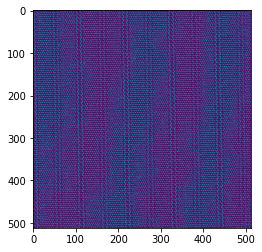

In [8]:
img = cv2.imread('C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Dataset/YDFID-1/SP3/TEST/defect/4.jpg', 0)
print(img.shape)
img_lbp= local_binary_pattern(img, 8, 1.0, 'ror')

cv2.imwrite('C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Output/1.jpg', img_lbp)

plt.imshow(img_lbp)
plt.show()




In [9]:
origin_path = 'C:/Users/kaka/PycharmProjects/pythonProject/AOI/zhiyong_fabric/origin2/'
crop_path = 'C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Dataset/'

get_data = False

def crop_resize_center_dataset(origin_path, crop_path, max_number=5000, crop_shape = (512, 512), resize_shape = (256,256)):
    floders = os.listdir(origin_path)
    for folder in floders:
        img_path2 = origin_path + folder
        save_path = crop_path + folder
        
        check_folder(save_path)
        
        cur_list = []

        # 影像存檔檔名
        count = 1
        for filename in os.listdir(img_path2):
            if 'jp' in filename:# or 'jpg' in filename):
                # 讀影像
                img = cv2.imread((img_path2 + '/' + filename), cv2.IMREAD_GRAYSCALE)
                cur_shape = img.shape
                x = int(cur_shape[0] / 2 - crop_shape[0] / 2)
                y = int(cur_shape[1] / 2 - crop_shape[1] / 2)
                # 擷取原始影像中800 x 640的部分
                crop_img = img[y:y+crop_shape[0], x:x+crop_shape[1]]
                
                resize_img= cv2.resize(crop_img, resize_shape, interpolation=cv2.INTER_NEAREST)
                
                cv2.imwrite((save_path + '/' + filename), resize_img)
                count += 1
            if count > max_number:
                break
                

                
if get_data:
    crop_resize_center_dataset(origin_path, crop_path)

# Match data

In [10]:
# Gabor
def Gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get half size
    d = K_size // 2

    # prepare kernel
    gabor = np.zeros((K_size, K_size), dtype=np.float32)

    # each value
    for y in range(K_size):
        for x in range(K_size):
            # distance from center
            px = x - d
            py = y - d

            # degree -> radian
            theta = angle / 180. * np.pi

            # get kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py

            # get kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py

            # fill kernel
            gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)

    # kernel normalization
    gabor /= np.sum(np.abs(gabor))

    return gabor


def Gabor_filtering(gray, K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get shape
    H, W = gray.shape

    # padding
    gray = np.pad(gray, (K_size//2, K_size//2), 'edge')

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # get gabor filter
    gabor = Gabor_filter(K_size=K_size, Sigma=Sigma, Gamma=Gamma, Lambda=Lambda, Psi=0, angle=angle)

    # filtering
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y : y + K_size, x : x + K_size] * gabor)

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out


def Gabor_process(gray):
    # get shape
    H, W = gray.shape

    # gray scale
   # gray = BGR2GRAY(img).astype(np.float32)

    # define angle
    As = [0, 45, 90, 135]

    # prepare pyplot
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

    out = np.zeros([H, W], dtype=np.float32)

    # each angle
    for i, A in enumerate(As):
        # gabor filtering
        _out = Gabor_filtering(gray, K_size=11, Sigma=1.5, Gamma=1.2, Lambda=3, angle=A)

        # add gabor filtered image
        out += _out

    # scale normalization
    out = out / out.max() * 255
    out = out.astype(np.uint8)

    return out

In [11]:
# all_semantic_test_data = all_test_data /255

for i in range(50):
    plt.imshow(np.concatenate((train_semantic_data[i], train_semantic_label[i]), axis = 1), 'gray')
    plt.show()

# Random data

In [12]:
def save_model_and_history(history, savePath):
    # loss
    loss = []
    val_loss = []
    accuracy = []
    val_accuracy = []
    mean_io_u = []
    val_mean_io_u = []

    
    for k,v in history.history.items():
        if 'val_loss' in k:
            val_loss = v
        elif 'loss' in k:
            loss = v
        elif 'val_accuracy' in k:
            val_accuracy = v
        elif 'accuracy' in k:
            accuracy = v 
        elif 'val_mean_io_u' in k:
            val_mean_io_u = v
        elif 'mean_io_u' in k:
            mean_io_u = v
            

    plt.plot(range(1, len(loss)+1), loss, 'b', label='Training loss')
    plt.plot(range(1, len(loss)+1), val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(savePath, f'loss.png'))
    plt.show()
    plt.clf()


    plt.plot(range(1, len(loss)+1), accuracy, 'b', label='Training accracy')
    plt.plot(range(1, len(loss)+1), val_accuracy, 'r', label='Validation accracy')
    plt.title('Training and validation accuracy')
    #plt.ylim([0.6, np.max(train_acc)])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(savePath, 'acc.png'))
    plt.show()


    df = pd.DataFrame({
        'accuracy':accuracy,
        'val_accuracy': val_accuracy,
        'loss': loss,
        'val_loss': val_loss
    })
    df.to_csv(savePath + '/history.csv', index=False)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D


def VGG16PART(input_shape):
    
    x = Conv2D(64, (3, 3), padding='same',activation='relu')(input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    return x

In [14]:
def siameseNetworkClassifier(classes = 3, input_shape = (256, 256, 1), start_neurons = 64):
    input_image_1 = Input((256, 256, 1))
    input_image_2 = Input((256, 256, 1))
    
    deconv_end1 = VGG16PART(input_image_1)
    deconv_end2 = VGG16PART(input_image_2)
    
    
    l1_distance_layer = Lambda(
        lambda tensors: K.abs(tensors[0] - tensors[1]))
    
    l1_distance = l1_distance_layer([deconv_end1, deconv_end2])
    
    print(l1_distance.shape)

    # Same class or not prediction
    prediction = Dense(units=classes, activation='sigmoid')(l1_distance)
    
    model = Model([input_image_1, input_image_2], prediction)
    
    return model
    

In [15]:
#coding=utf-8
import tensorflow as tf
import keras 
from keras.models import *
from keras.layers import *

def conv_block(input, filters):
    out = Conv2D(filters, kernel_size=(3,3), strides=1, padding='same')(input)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Conv2D(filters, kernel_size=(3,3), strides=1, padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    return out

def up_conv(input, filters):
    out = UpSampling2D()(input)
    out = Conv2D(filters, kernel_size=(3,3), strides=1, padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    return out

def Attention_block(input1, input2, filters):
    g1 = Conv2D(filters, kernel_size=1, strides=1, padding='same')(input1)
    g1 = BatchNormalization()(g1)
    x1 = Conv2D(filters, kernel_size=1, strides=1, padding='same')(input2)
    x1 = BatchNormalization()(x1)
    psi = Activation('relu')(add([g1, x1]))
    psi = Conv2D(filters, kernel_size=1, strides=1, padding='same')(psi)
    psi = BatchNormalization()(psi)
    psi = Activation('sigmoid')(psi)
    out = multiply([input2, psi])
    return out

def Recurrent_block(input, channel, t=2):
    for i in range(t):
        if i == 0:
            x = Conv2D(channel, kernel_size=(3, 3), strides=1, padding='same')(input)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        out = Conv2D(channel, kernel_size=(3, 3), strides=1, padding='same')(add([x, x]))
        out = BatchNormalization()(out)
        out = Activation('relu')(out)
    return out

def RRCNN_block(input, channel, t=2):
    x1 = Conv2D(channel, kernel_size=(1, 1), strides=1, padding='same')(input)
    x2 = Recurrent_block(x1, channel, t=t)
    x2 = Recurrent_block(x2, channel, t=t)
    out = add([x1, x2])
    return out



def R2AttUNet(nClasses, input_shape = (256, 256, 1)):
    # """
    #Residual Recuurent Block with attention Unet
    #Implementation : https://github.com/LeeJunHyun/Image_Segmentation
    #"""
    inputs = Input(shape=input_shape)
    t = 2
    n1 = 32
    filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

    e1 = RRCNN_block(inputs, filters[0], t=t)

    e2 = MaxPooling2D(strides=2)(e1)
    e2 = RRCNN_block(e2, filters[1], t=t)

    e3 = MaxPooling2D(strides=2)(e2)
    e3 = RRCNN_block(e3, filters[2], t=t)

    e4 = MaxPooling2D(strides=2)(e3)
    e4 = RRCNN_block(e4, filters[3], t=t)

    e5 = MaxPooling2D(strides=2)(e4)
    e5 = RRCNN_block(e5, filters[4], t=t)

    d5 = up_conv(e5, filters[3])
    x4 =  Attention_block(d5, e4, filters[3])
    d5 = Concatenate()([x4, d5])
    d5 = conv_block(d5, filters[3])

    d4 = up_conv(d5, filters[2])
    x3 =  Attention_block(d4, e3, filters[2])
    d4 = Concatenate()([x3, d4])
    d4 = conv_block(d4, filters[2])

    d3 = up_conv(d4, filters[1])
    x2 =  Attention_block(d3, e2, filters[1])
    d3 = Concatenate()([x2, d3])
    d3 = conv_block(d3, filters[1])

    d2 = up_conv(d3, filters[0])
    x1 =  Attention_block(d2, e1, filters[0])
    d2 = Concatenate()([x1, d2])
    d2 = conv_block(d2, filters[0])

    out = Conv2D(nClasses, (3, 3), padding='same')(d2)


    model = Model(inputs=inputs, outputs=out)

    return model

In [16]:
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, BatchNormalization, Input, DepthwiseConv2D, add,Dropout, AveragePooling2D, Concatenate, Layer, InputSpec
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils import conv_utils
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.utils import conv_utils

from keras.utils.data_utils import get_file
from keras.utils.conv_utils import normalize_data_format


class BilinearUpsampling(Layer):

    def __init__(self, upsampling=(2, 2), data_format=None, **kwargs):
        super(BilinearUpsampling, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        self.upsampling = conv_utils.normalize_tuple(upsampling, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        height = self.upsampling[0] * \
                 input_shape[1] if input_shape[1] is not None else None
        width = self.upsampling[1] * \
                input_shape[2] if input_shape[2] is not None else None
        return (input_shape[0], height, width, input_shape[3])

    def call(self, inputs):
        # .tf
        return tf.compat.v1.image.resize_bilinear(inputs, (int(inputs.shape[1] * self.upsampling[0]),
                                                 int(inputs.shape[2] * self.upsampling[1])))

    def get_config(self):

        config = {'size': self.upsampling, 'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def xception_downsample_block(x, channels, top_relu=False):
    ##separable conv1
    if top_relu:
        x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    ##separable conv2
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    ##separable conv3
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def res_xception_downsample_block(x, channels):
    res = Conv2D(channels, (1, 1), strides=(2, 2), padding="same", use_bias=False)(x)
    res = BatchNormalization()(res)
    x = xception_downsample_block(x, channels)
    x = add([x, res])
    return x


def xception_block(x, channels):
    ##separable conv1
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    ##separable conv2
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    ##separable conv3
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def res_xception_block(x, channels):
    res = x
    x = xception_block(x, channels)
    x = add([x, res])
    return x


def aspp(x, input_shape, out_stride = 8):
    b0 = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    b0 = BatchNormalization()(b0)
    b0 = Activation("relu")(b0)

    b1 = DepthwiseConv2D((3, 3), dilation_rate=(6, 6), padding="same", use_bias=False)(x)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b1 = Conv2D(256, (1, 1), padding="same", use_bias=False)(b1)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)

    b2 = DepthwiseConv2D((3, 3), dilation_rate=(12, 12), padding="same", use_bias=False)(x)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    b2 = Conv2D(256, (1, 1), padding="same", use_bias=False)(b2)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)

    b3 = DepthwiseConv2D((3, 3), dilation_rate=(12, 12), padding="same", use_bias=False)(x)
    b3 = BatchNormalization()(b3)
    b3 = Activation("relu")(b3)
    b3 = Conv2D(256, (1, 1), padding="same", use_bias=False)(b3)
    b3 = BatchNormalization()(b3)
    b3 = Activation("relu")(b3)

    out_shape = int(input_shape[0] / out_stride)
    b4 = AveragePooling2D(pool_size=(out_shape, out_shape))(x)
    b4 = Conv2D(256, (1, 1), padding="same", use_bias=False)(b4)
    b4 = BatchNormalization()(b4)
    b4 = Activation("relu")(b4)
    b4 = BilinearUpsampling((out_shape, out_shape))(b4)

    x = Concatenate()([b4, b0, b1, b2, b3])
    return x


def DeeplabV3_plus(nClasses=21, input_shape = (256, 256, 1), out_stride=16):
    img_input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), padding="same", use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = res_xception_downsample_block(x, 128)

    res = Conv2D(256, (1, 1), strides=(2, 2), padding="same", use_bias=False)(x)
    res = BatchNormalization()(res)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    skip = BatchNormalization()(x)
    x = Activation("relu")(skip)
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x, res])

    x = xception_downsample_block(x, 728, top_relu=True)

    for i in range(16):
        x = res_xception_block(x, 728)

    res = Conv2D(1024, (1, 1), padding="same", use_bias=False)(x)
    res = BatchNormalization()(res)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(728, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(1024, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(1024, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x, res])

    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(1536, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(1536, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(2048, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # aspp
    x = aspp(x, input_shape, out_stride)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.9)(x)

    ##decoder
    x = BilinearUpsampling((4, 4))(x)
    dec_skip = Conv2D(48, (1, 1), padding="same", use_bias=False)(skip)
    dec_skip = BatchNormalization()(dec_skip)
    dec_skip = Activation("relu")(dec_skip)
    x = Concatenate()([x, dec_skip])

    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(nClasses, (1, 1), padding="same")(x)
    x = BilinearUpsampling((4, 4))(x)
#     outputHeight = Model(img_input, x).output_shape[1]
#     outputWidth = Model(img_input, x).output_shape[2]
#     x = (Reshape((outputHeight * outputWidth, nClasses)))(x)
#     x = Activation('softmax')(x)
    model = Model(img_input, x)
    return model



In [17]:

from tensorflow.keras import layers

def Unet(input_shape = (256,256, 1), num_classes = 2):
    inputs = keras.Input(shape=input_shape)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model



In [18]:
lbc_s = {}

def lnp_conv(ip, filters, kernel_size = 3, stride=1, padding='same', activation='relu', dilation=1, name=None, point_filters=0, sparsity=0.5):    
    x =  LBC(filters=filters, kernel_size=kernel_size, stride=stride, padding=padding, activation='relu', name=name, dilation=dilation, sparsity=sparsity)(ip)
    return x

def residual(ip, filters, kernel_size=3, name=None, sparsity=0.5):
    x = Conv2D(filters=filters, kernel_size=1, padding='same')(ip)
    x = lnp_conv(x, filters=filters, point_filters=filters, kernel_size=kernel_size, sparsity=sparsity)
    return Add()([ip,x])

In [19]:
def residual_dense_block(input_layer, start_neurons = 64):

    x1_1 = Conv2D(start_neurons, (3, 3), activation="relu", padding="same")(input_layer)

    x1_1_concat = concatenate([input_layer, x1_1])
    x1_2 = Conv2D(start_neurons, (3, 3), activation="relu", padding="same")(x1_1_concat)

    x1_2_concat = concatenate([input_layer, x1_1, x1_2])
    x1_3 = Conv2D(start_neurons, (3, 3), activation="relu", padding="same")(x1_2_concat)

    x1_3_concat = concatenate([input_layer, x1_1, x1_2, x1_3])
    x1_3 = Conv2D(start_neurons, (1, 1), activation="relu", padding="same")(x1_3_concat)

    output_layer = concatenate([input_layer, x1_3])

    return output_layer


In [20]:
def aspp(x, input_shape, out_stride, dilation_rates = (6, 12, 18, 24),   channel = 256):
    b0 = Conv2D(channel, (1, 1), padding="same", use_bias=False)(x)
    b0 = BatchNormalization()(b0)
    b0 = Activation("relu")(b0)

    b1 = DepthwiseConv2D((3, 3), dilation_rate=(dilation_rates[0], dilation_rates[0]), padding="same", use_bias=False)(x)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b1 = Conv2D(channel, (1, 1), padding="same", use_bias=False)(b1)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)

    b2 = DepthwiseConv2D((3, 3), dilation_rate=(dilation_rates[1], dilation_rates[1]), padding="same", use_bias=False)(x)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    b2 = Conv2D(channel, (1, 1), padding="same", use_bias=False)(b2)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)

    b3 = DepthwiseConv2D((3, 3), dilation_rate=(dilation_rates[2], dilation_rates[2]), padding="same", use_bias=False)(x)
    b3 = BatchNormalization()(b3)
    b3 = Activation("relu")(b3)
    b3 = Conv2D(channel, (1, 1), padding="same", use_bias=False)(b3)
    b3 = BatchNormalization()(b3)
    b3 = Activation("relu")(b3)

    out_shape = int(input_shape[0] / out_stride)
    b4 = AveragePooling2D(pool_size=(out_shape, out_shape))(x)
    b4 = Conv2D(channel, (1, 1), padding="same", use_bias=False)(b4)
    b4 = BatchNormalization()(b4)
    b4 = Activation("relu")(b4)
    b4 = BilinearUpsampling((out_shape, out_shape))(b4)

    x = Concatenate()([b4, b0, b1, b2, b3])
    return x


def Attention_block(input1, input2, filters):
    
    print('*' * 8)
    print(input1.shape, input2.shape)
    g1 = Conv2D(filters, kernel_size=1, strides=1, padding='same')(input1)
    g1 = BatchNormalization()(g1)
    x1 = Conv2D(filters, kernel_size=1, strides=1, padding='same')(input2)
    x1 = BatchNormalization()(x1)
    
    print(g1.shape, x1.shape)
    psi = Activation('relu')(add([g1, x1]))
    
    print(psi.shape)
    psi = Conv2D(filters, kernel_size=1, strides=1, padding='same')(psi)
    psi = BatchNormalization()(psi)
    psi = Activation('sigmoid')(psi)
    
    out = multiply([input2, psi])
    print(out.shape)
    return out

In [21]:
def design_network(input_shape = (256, 256, 1),
          kernel = 3,
          start_neurons = 64, 
          classes=10):

    dilation_rates = (6, 12, 18, 24)
    
    img_input = Input(shape=input_shape, name = 'input')
# attach_attention_module
    # block 1
    
    conv1_aspp =aspp(img_input, input_shape, out_stride = 16, dilation_rates = dilation_rates,   channel = start_neurons * 1)
    
#     print(conv1_aspp.shape)
#     conv1_first = lnp_conv(img_input, filters=start_neurons * 1, kernel_size = kernel, name = 'lbp1')
    conv1_first = residual_dense_block(conv1_aspp)
    conv1 = BatchNormalization()(conv1_first)
    conv1 = attach_attention_module(conv1)
    conv1 = Conv2D(start_neurons * 1, (kernel, kernel), activation="relu", padding="same")(conv1)
    conv1_end = Conv2D(start_neurons * 1, (kernel, kernel), activation="relu", padding="same")(conv1)
    
    resodual_layer1 = concatenate([conv1_first, conv1])
    conv1_last = Activation('relu')(resodual_layer1)
    pool1 = MaxPooling2D((2, 2))(conv1_last)
    
    # block 2
#     conv1_first = lnp_conv(pool1, filters=start_neurons * 1, kernel_size = kernel, name = 'lbp2')
    conv2_first = residual_dense_block(pool1)
    conv2 = BatchNormalization()(conv2_first)
    conv2 = attach_attention_module(conv2)
    conv2 = Conv2D(start_neurons * 2, (kernel, kernel), activation="relu", padding="same")(conv2)
    conv2_end = Conv2D(start_neurons * 2, (kernel, kernel), activation="relu", padding="same")(conv2)

    
    resodual_layer2 = concatenate([conv2_first, conv2])
    conv2_last = Activation('relu')(resodual_layer2)
    pool2 = MaxPooling2D((2, 2))(conv2_last)
    
    # block 3
#     conv3_first = lnp_conv(pool2, filters=start_neurons * 1, kernel_size = kernel, name = 'lbp3')
    conv3_first = residual_dense_block(pool2)
    conv3 = BatchNormalization()(conv3_first)
    conv3 = attach_attention_module(conv3)
    conv3 = Conv2D(start_neurons * 4, (kernel, kernel), activation="relu", padding="same")(conv3)
    conv3_end = Conv2D(start_neurons * 4, (kernel, kernel), activation="relu", padding="same")(conv3)
    
    resodual_layer3 = concatenate([conv3_first, conv3_end])
    conv3_last = Activation('relu')(resodual_layer3)
    pool3 = MaxPooling2D((2, 2))(conv3_last)
    
    # middle
    convm = Conv2D(start_neurons * 8, (kernel, kernel), activation="relu", padding="same")(pool3)
    convm = Conv2D(start_neurons * 8, (kernel, kernel), activation="relu", padding="same")(convm)
    deconv3 = Conv2DTranspose(start_neurons * 4, (kernel, kernel), strides=(2, 2), padding="same")(convm)
    
    # unblock 3
    uconv3_resodual =  Attention_block(deconv3, conv3_end, start_neurons * 4)
#     uconv3_resodual = concatenate([conv3_first, deconv3])
    uconv3_resodual = attach_attention_module(uconv3_resodual)
    uconv3 = Conv2D(start_neurons * 4, (kernel, kernel), activation="relu", padding="same")(uconv3_resodual)
    uconv3 = Conv2D(start_neurons * 4, (kernel, kernel), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    deconv2 = Conv2DTranspose(start_neurons * 2, (kernel, kernel), strides=(2, 2), padding="same")(uconv3)
    
    # unblock 2
    uconv2_resodual =  Attention_block(deconv2, conv2_end, start_neurons * 2)
#     uconv2_resodual = concatenate([conv2_first, deconv2])
    uconv2_resodual = attach_attention_module(uconv2_resodual)
    uconv2 = Conv2D(start_neurons * 2, (kernel, kernel), activation="relu", padding="same")(uconv2_resodual)
    uconv2 = Conv2D(start_neurons * 2, (kernel, kernel), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (kernel, kernel), strides=(2, 2), padding="same")(uconv2)

    # unblock 1
    uconv1_resodual =  Attention_block(deconv1, conv1_end, start_neurons * 1)  
#     uconv1_resodual = concatenate([conv1_first, deconv1])
    uconv1_resodual = attach_attention_module(uconv1_resodual)
    uconv1 = Conv2D(start_neurons * 1, (kernel, kernel), activation="relu", padding="same")(uconv1_resodual)
    uconv1 = Conv2D(start_neurons * 1, (kernel, kernel), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)

    # output
    output_layer = Conv2D(2, (1, 1), padding="same", activation="sigmoid",  name = 'output')(uconv1)


    model = Model(img_input, output_layer, name='CNN')
    return model

# model2 = design_network(input_shape = (256, 256, 1))
# model2.summary()

********
(None, 64, 64, 256) (None, 64, 64, 256)
(None, 64, 64, 256) (None, 64, 64, 256)
(None, 64, 64, 256)
(None, 64, 64, 256)
********
(None, 128, 128, 128) (None, 128, 128, 128)
(None, 128, 128, 128) (None, 128, 128, 128)
(None, 128, 128, 128)
(None, 128, 128, 128)
********
(None, 256, 256, 64) (None, 256, 256, 64)
(None, 256, 256, 64) (None, 256, 256, 64)
(None, 256, 256, 64)
(None, 256, 256, 64)


In [22]:
def get_model_size(model):
    para_num = sum([np.prod(w.shape) for w in model.get_weights()])
    # para_size: 参数个数 * 每个4字节(float32) / 1024 / 1024，单位为 MB
    para_size = para_num * 4 / 1024 / 1024
    return para_size

In [23]:
def LBCNN3(input_shape = (256, 256, 1),
          kernel = 3,
          start_neurons = 64, 
          classes=10):

    
    img_input = Input(shape=input_shape, name = 'input')
# attach_attention_module
    # block 1
    conv1_first = residual_dense_block(img_input)
    conv1 = BatchNormalization()(conv1_first)
    conv1 = attach_attention_module(conv1)
    conv1 = Conv2D(start_neurons * 1, (kernel, kernel), activation="relu", padding="same")(conv1)
#     conv1 = Conv2D(start_neurons * 1, (kernel, kernel), activation="relu", padding="same")(conv1)
    
    resodual_layer1 = concatenate([conv1_first, conv1])
    conv1_last = Activation('relu')(resodual_layer1)
    pool1 = MaxPooling2D((2, 2))(conv1_last)
    
    # block 2
    conv2_first = residual_dense_block(pool1)
    conv2 = BatchNormalization()(conv2_first)
    conv2 = attach_attention_module(conv2)
    conv2 = Conv2D(start_neurons * 2, (kernel, kernel), activation="relu", padding="same")(conv2)
#     conv2 = Conv2D(start_neurons * 2, (kernel, kernel), activation="relu", padding="same")(conv2)

    
    resodual_layer2 = concatenate([conv2_first, conv2])
    conv2_last = Activation('relu')(resodual_layer2)
    pool2 = MaxPooling2D((2, 2))(conv2_last)
    
    # block 3
    conv3_first = residual_dense_block(pool2)
    conv3 = BatchNormalization()(conv3_first)
    conv3 = attach_attention_module(conv3)
    conv3 = Conv2D(start_neurons * 4, (kernel, kernel), activation="relu", padding="same")(conv3)
#     conv3 = Conv2D(start_neurons * 4, (kernel, kernel), activation="relu", padding="same")(conv3)
    
    resodual_layer3 = concatenate([conv3_first, conv3])
    conv3_last = Activation('relu')(resodual_layer3)
    pool3 = MaxPooling2D((2, 2))(conv3_last)
    
    # middle
    convm = Conv2D(start_neurons * 8, (kernel, kernel), activation="relu", padding="same")(pool3)
    convm = Conv2D(start_neurons * 8, (kernel, kernel), activation="relu", padding="same")(convm)
    deconv3 = Conv2DTranspose(start_neurons * 4, (kernel, kernel), strides=(2, 2), padding="same")(convm)
    
    # unblock 3
    uconv3_resodual = concatenate([conv3_first, deconv3])
    uconv3_resodual = attach_attention_module(uconv3_resodual)
    uconv3 = Conv2D(start_neurons * 4, (kernel, kernel), activation="relu", padding="same")(uconv3_resodual)
#     uconv3 = Conv2D(start_neurons * 4, (kernel, kernel), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    deconv2 = Conv2DTranspose(start_neurons * 2, (kernel, kernel), strides=(2, 2), padding="same")(uconv3)
    
    # unblock 2
    uconv2_resodual = concatenate([conv2_first, deconv2])
    uconv2_resodual = attach_attention_module(uconv2_resodual)
    uconv2 = Conv2D(start_neurons * 2, (kernel, kernel), activation="relu", padding="same")(uconv2_resodual)
#     uconv2 = Conv2D(start_neurons * 2, (kernel, kernel), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (kernel, kernel), strides=(2, 2), padding="same")(uconv2)

    # unblock 1
    uconv1_resodual = concatenate([conv1_first, deconv1])
    uconv1_resodual = attach_attention_module(uconv1_resodual)
    uconv1 = Conv2D(start_neurons * 1, (kernel, kernel), activation="relu", padding="same")(uconv1_resodual)
#     uconv1 = Conv2D(start_neurons * 1, (kernel, kernel), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)

    # output
    output_layer = Conv2D(2, (1, 1), padding="same", activation="sigmoid",  name = 'output')(uconv1)


    model = Model(img_input, output_layer, name='CNN')
    return model

In [24]:
def RDUnetPart(img_input, cur_type = '_1', start_neurons = 64):

    conv1 = Conv2D(start_neurons, (1, 1), padding="same")(img_input)
    x = Conv2D(start_neurons, (1, 1),padding="same")(conv1)

    # block 1
    #x1 = attach_attention_module(x)
    x1 = residual_dense_block(x)
    pool1 = MaxPooling2D((2, 2))(x1)

    # block 2
    #x2 = attach_attention_module(pool1)
    x2 = residual_dense_block(pool1)
    pool2 = MaxPooling2D((2, 2))(x2)

    # block 3
    #x3 = attach_attention_module(pool2)
    x3 = residual_dense_block(pool2)
    pool3 = MaxPooling2D((2, 2))(x3)

    # block 4
    #x4 = attach_attention_module(pool3)
    x4 = residual_dense_block(pool3)
    pool4 = MaxPooling2D((2, 2))(x4)

    x_middle = Conv2D(start_neurons, (1, 1), activation="relu", padding="same")(pool4)
    x_middle = Conv2D(start_neurons, (1, 1), activation="relu", padding="same")(x_middle)

    deconv4 = Conv2DTranspose(start_neurons , (3, 3), strides=(2, 2), padding="same")(x_middle)
    uconv4_atten = attach_attention_module(deconv4)
    x4_concat = concatenate([x4, uconv4_atten], name=f'concat_1{cur_type}')

    deconv3 = Conv2DTranspose(start_neurons , (3, 3), strides=(2, 2), padding="same")(x4_concat)
    uconv3_atten = attach_attention_module(deconv3)
    x3_concat = concatenate([x3, uconv3_atten], name=f'concat_2{cur_type}')

    deconv2 = Conv2DTranspose(start_neurons , (3, 3), strides=(2, 2), padding="same")(x3_concat)
    uconv2_atten = attach_attention_module(deconv2)
    x2_concat = concatenate([x2, uconv2_atten], name=f'concat_3{cur_type}')

    deconv1 = Conv2DTranspose(start_neurons , (3, 3), strides=(2, 2), padding="same")(x2_concat)
    uconv1_atten = attach_attention_module(deconv1)
    x1_concat = concatenate([x1, uconv1_atten], name=f'concat_4{cur_type}')

    deconv = residual_dense_block(x1_concat)
    deconv_end = Conv2D(start_neurons, (1, 1), activation="relu", padding="same")(deconv)
    
    return deconv_end


def RDUnet(classes = 2, input_shape = (256, 256, 1), start_neurons = 64):
    img_input = Input(shape=input_shape, name = 'input')
    
    deconv_end = RDUnetPart(img_input, start_neurons)
    
    prediction = Conv2D(classes, (3, 3), activation="relu", padding="same")(deconv_end)
    model = Model(img_input, prediction, name='CNN')

    return model

In [25]:
def siameseNetworkSemantic(classes = 2, input_shape = (256, 256, 1), start_neurons = 64):
    input_image_1 = Input(input_shape)
    input_image_2 = Input(input_shape)
    
    deconv_end1 = RDUnetPart(input_image_1, cur_type = '_1', start_neurons = start_neurons)
    deconv_end2 = RDUnetPart(input_image_2, cur_type = '_2', start_neurons = start_neurons)
    
    
    l1_distance_layer = Lambda(
        lambda tensors: K.abs(tensors[0] - tensors[1]))
    
    l1_distance = l1_distance_layer([deconv_end1, deconv_end2])

    # Same class or not prediction
    prediction = Conv2D(classes, (3, 3), activation="relu", padding="same")(l1_distance)
    
    model = Model(inputs=[input_image_1, input_image_2], outputs=prediction)
    
    return model
        

In [26]:
def siameseNetwork(classes = 2, input_shape = (256, 256, 1), start_neurons = 64):
    input_image_1 = Input(input_shape)
    input_image_2 = Input(input_shape)
    
    deconv_end1 = RDUnetPart(input_image_1, cur_type = '_1', start_neurons = start_neurons)
    deconv_end2 = RDUnetPart(input_image_2, cur_type = '_2', start_neurons = start_neurons)
    
    
    l1_distance_layer = Lambda(
        lambda tensors: K.abs(tensors[0] + tensors[1]))
    
    l1_distance = l1_distance_layer([deconv_end1, deconv_end2])

    # Same class or not prediction
    prediction = Conv2D(classes, (3, 3), activation="relu", padding="same")(l1_distance)
    
    model = Model(inputs=[input_image_1, input_image_2], outputs=prediction)
    
    return model
        

## Mobilenet v3


MobileNetV3_Small(inputs)
MobileNetV3_Large()


tiny_yolo_body(inputs, num_anchors, num_classes)

yolo_body(inputs, num_anchors, num_classes)

In [27]:
# MobileNetV3_Small(inputs = (256,256, 3))

In [28]:
from keras.layers import Conv2D, DepthwiseConv2D, Dense, GlobalAveragePooling2D,UpSampling2D, Concatenate
from keras.layers import Activation, BatchNormalization, Add, Multiply, Reshape
from keras import backend as K
from keras.models import Model
import tensorflow as tf
# 定义relu6激活函数
def relu6(x):
    return K.relu(x, max_value=6.0)
# 定义h-swish激活函数
def hard_swish(x):
    return x * K.relu(x + 3.0, max_value=6.0) / 6.0
# 定义返回的激活函数是relu6还是h-swish
def return_activation(x, nl):
    if nl == 'HS':
        x = Activation(hard_swish)(x)
    if nl == 'RE':
        x = Activation(relu6)(x)
    return x
# 定义卷积块(卷积+标准化+激活函数)
def conv_block(inputs, filters, kernel, strides, nl):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return return_activation(x, nl)
# 定义注意力机制模块
def SE(inputs):
    input_channels = int(inputs.shape[-1])
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(input_channels, activation='relu')(x)
    x = Dense(input_channels, activation='hard_sigmoid')(x)
    x = Reshape((1, 1, input_channels))(x)
    x = Multiply()([inputs, x])
    return x

def bottleneck(inputs, filters, kernel, e, s, squeeze, nl,alpha=1.0):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    input_shape = K.int_shape(inputs)
    tchannel = int(e)
    cchannel = int(alpha * filters)
    r = s == 1 and input_shape[3] == filters
    x = conv_block(inputs, tchannel, (1,1), (1,1), nl)
    x = DepthwiseConv2D(kernel, strides=(s,s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = [](x,nl)
    if squeeze:
        x = SE(x)
    x = Conv2D(cchannel, (1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    if r:
        x = Add()([x, inputs])
    return x

def MobileNetV3_Large(inputs, alpha=1.0):
    # conv2d_1 (Conv2D) - activation_1 (Activation)
    x = conv_block(inputs, 16, (3,3), strides=(2,2), nl='HS')
    # conv2d_2 (Conv2D) - add_1 (Add)
    x = bottleneck(x, 16, (3, 3), e=16, s=1, squeeze=False, nl='RE', alpha=alpha)
    # conv2d_4 (Conv2D) - batch_normalization_7
    x = bottleneck(x, 24, (3, 3), e=64, s=2, squeeze=False, nl='RE', alpha=alpha)
    # conv2d_6 (Conv2D) - add_2 (Add)
    x = bottleneck(x, 24, (3, 3), e=72, s=1, squeeze=False, nl='RE', alpha=alpha)
    # conv2d_8 (Conv2D) - batch_normalization_13
    x = bottleneck(x, 40, (5, 5), e=72, s=2, squeeze=True, nl='RE', alpha=alpha)
    # conv2d_10 (Conv2D) - add_3 (Add)
    x = bottleneck(x, 40, (5, 5), e=120, s=1, squeeze=True, nl='RE', alpha=alpha)
    # conv2d_12 (Conv2D) - add_4 (Add)   (None, 52, 52, 40)    70层
    x = bottleneck(x, 40, (5, 5), e=120, s=1, squeeze=True, nl='RE', alpha=alpha)



    # conv2d_14 (Conv2D) - batch_normalization_22  (None, 26, 26, 80)
    x = bottleneck(x, 80, (3, 3), e=240, s=2, squeeze=False, nl='HS', alpha=alpha)
    # conv2d_16 (Conv2D) - add_5 (Add)   (None, 26, 26, 80)
    x = bottleneck(x, 80, (3, 3), e=200, s=1, squeeze=False, nl='HS', alpha=alpha)
    # conv2d_18 (Conv2D) - add_6 (Add)
    x = bottleneck(x, 80, (3, 3), e=184, s=1, squeeze=False, nl='HS', alpha=alpha)
    # conv2d_20 (Conv2D) - add_7 (Add)    (None, 26, 26, 80)
    x = bottleneck(x, 80, (3, 3), e=184, s=1, squeeze=False, nl='HS', alpha=alpha)
    # conv2d_22 (Conv2D) - batch_normalization_34   (None, 26, 26, 112)
    # inputs=(26,26,80) filtters=112 所以没有Add
    x = bottleneck(x, 112, (3, 3), e=480, s=1, squeeze=True, nl='HS', alpha=alpha)
    # conv2d_24 (Conv2D) - add_8 (Add)   (None, 26, 26, 112)     132层
    x = bottleneck(x, 112, (3, 3), e=672, s=1, squeeze=True, nl='HS', alpha=alpha)



    # conv2d_26 (Conv2D) - batch_normalization_40   (None, 13, 13, 160)
    x = bottleneck(x, 160, (5, 5), e=672, s=2, squeeze=True, nl='HS', alpha=alpha)
    # conv2d_28 (Conv2D) - add_9 (Add)   (None, 13, 13, 160)
    x = bottleneck(x, 160, (5, 5), e=960, s=1, squeeze=True, nl='HS', alpha=alpha)
    # conv2d_30 (Conv2D) - add_10 (Add)  (None, 13, 13, 160)
    x = bottleneck(x, 160, (5, 5), e=960, s=1, squeeze=True, nl='HS', alpha=alpha)
    model = Model(inputs, x)
    return model

def MobileNetV3_Small(inputs, alpha=1.0):
    x = conv_block(inputs, 16, (3, 3), strides=(2, 2), nl='HS')
    x = bottleneck(x, 16, (3, 3), e=16, s=2, squeeze=True, nl='RE', alpha=alpha)
    x = bottleneck(x, 24, (3, 3), e=72, s=2, squeeze=False, nl='RE', alpha=alpha)
    x = bottleneck(x, 24, (3, 3), e=88, s=1, squeeze=False, nl='RE', alpha=alpha)
    x = bottleneck(x, 40, (5, 5), e=96, s=2, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 40, (5, 5), e=240, s=1, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 40, (5, 5), e=240, s=1, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 48, (5, 5), e=120, s=1, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 48, (5, 5), e=144, s=1, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 96, (5, 5), e=288, s=2, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 96, (5, 5), e=576, s=1, squeeze=True, nl='HS', alpha=alpha)
    x = bottleneck(x, 96, (5, 5), e=576, s=1, squeeze=True, nl='HS', alpha=alpha)
    model = Model(inputs, x)
    return model

def make_last_layers(x, num_filters, out_filters):
    x = conv_block(x, num_filters, (1, 1), strides=(1, 1), nl='HS')
    x = conv_block(x, num_filters, (3, 3), strides=(1, 1), nl='HS')
    x = conv_block(x, num_filters, (1, 1), strides=(1, 1), nl='HS')
    y = conv_block(x, num_filters, (3, 3), strides=(1, 1), nl='HS')
    y = Conv2D(out_filters, (1, 1), strides=(1, 1), padding='same')(y)
    return x, y

def yolo_body(inputs, num_anchors, num_classes):
    mobilenet = MobileNetV3_Large(inputs)
    x, y1 = make_last_layers(mobilenet.output, 160, num_anchors*(num_classes+5))
    x = conv_block(x, 112, (1, 1), strides=(1, 1),nl='HS')
    x = UpSampling2D(2)(x)
    x = Concatenate()([x,mobilenet.layers[132].output])
    x, y2 = make_last_layers(x, 112, num_anchors*(num_classes+5))
    x = conv_block(x, 80, (1, 1), strides=(1, 1),nl='HS')
    x = UpSampling2D(2)(x)
    x = Concatenate()([x,mobilenet.layers[70].output])
    x, y3 = make_last_layers(x, 80, num_anchors*(num_classes+5))
    return Model(inputs, [y1,y2,y3])

def tiny_yolo_body(inputs, num_anchors, num_classes):
    mobilenet = MobileNetV3_Small(inputs)
    x = conv_block(mobilenet.output, 96, (3, 3), strides=(1, 1), nl='HS')
    y1 = Conv2D(num_anchors*(num_classes+5), (1, 1), strides=(1, 1), padding='same')(x)
    x = UpSampling2D(2)(mobilenet.output)
    x = Concatenate()([x, mobilenet.layers[104].output])
    x = conv_block(x, 96, (3, 3), strides=(1, 1), nl='HS')
    y2 = Conv2D(num_anchors*(num_classes+5), (1, 1), strides=(1, 1), padding='same')(x)
    return Model(inputs, [y1,y2])

def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    num_anchors = len(anchors)
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])
    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))
    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])
    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape):
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = K.cast(input_shape, K.dtype(box_yx))
    image_shape = K.cast(image_shape, K.dtype(box_yx))
    new_shape = K.round(image_shape * K.min(input_shape/image_shape))
    offset = (input_shape-new_shape)/2./input_shape
    scale = input_shape/new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale
    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes =  K.concatenate([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ])
    boxes *= K.concatenate([image_shape, image_shape])
    return boxes

def yolo_boxes_and_scores(feats, anchors, num_classes, input_shape, image_shape):
    box_xy, box_wh, box_confidence, box_class_probs = yolo_head(feats,
        anchors, num_classes, input_shape)
    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = K.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = K.reshape(box_scores, [-1, num_classes])
    return boxes, box_scores

def yolo_eval(yolo_outputs,
              anchors,
              num_classes,
              image_shape,
              max_boxes=50,
              score_threshold=.6,
              iou_threshold=.4):
    num_layers = len(yolo_outputs)
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]] # default setting
    input_shape = K.shape(yolo_outputs[0])[1:3] * 32
    boxes = []
    box_scores = []
    for l in range(num_layers):
        _boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[l],
            anchors[anchor_mask[l]], num_classes, input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = K.concatenate(boxes, axis=0)
    box_scores = K.concatenate(box_scores, axis=0)
    mask = box_scores >= score_threshold
    max_boxes_tensor = K.constant(max_boxes, dtype='int32')
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(num_classes):
        class_boxes = tf.boolean_mask(boxes, mask[:, c])
        class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])
        nms_index = tf.image.non_max_suppression(
            class_boxes, class_box_scores, max_boxes_tensor, iou_threshold=iou_threshold)
        class_boxes = K.gather(class_boxes, nms_index)
        class_box_scores = K.gather(class_box_scores, nms_index)
        classes = K.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)
    boxes_ = K.concatenate(boxes_, axis=0)
    scores_ = K.concatenate(scores_, axis=0)
    classes_ = K.concatenate(classes_, axis=0)
    return boxes_, scores_, classes_

# GET DATA

In [29]:
# crop_path = 'C:/Users/kaka/PycharmProjects/pythonProject/AOI/zhiyong_fabric/dataset/DefectDetect/243/test_img/'
# save_test_path = f'C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Dataset/Test/243/'

# LBP_state = False
# Gabor_state = False

# DATASET = 'MVTEC'

# cur_data = 'wood'
def getEXPData(DATASET, cur_data, input_shape):

    dataset_path = f'C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Dataset/{DATASET}/{cur_data}/Train/defect-free'
    path_0utput = f'C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Output/{DATASET}'


    all_normal_data, all_defect_data, all_defect_label = readData(dataset_path, cur_data, input_shape)


    all_normal_data_shape = all_normal_data.shape
    all_normal_label = np.zeros((all_normal_data_shape[0], all_normal_data_shape[1], all_normal_data_shape[2], 1))

    normal_classifier_label = np.zeros(len(all_normal_data))
    defect_classifier_label = np.ones(len(all_defect_data))


    test_path = f'C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Dataset/{DATASET}/{cur_data}/TEST/defect/'
    mask_path = f'C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Dataset/{DATASET}/{cur_data}/TEST/groundtruth/'
    # test_path = f'C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Dataset/Test/{cur_data}/'
    # all_test_data, all_test_file = readDefectData(test_path)
    all_test_data, all_test_file, all_defect_mask = readDefectData(test_path, mask_path, image_size = input_shape)


    classifier = False


    if classifier:
        all_data = np.concatenate((all_normal_data[:Train_normal_len], all_defect_data[:Train_defect_len]), axis=0)/255
        all_data2 = np.concatenate((all_normal_data[Train_normal_len: Train_normal_len *2], all_defect_data[Train_defect_len: Train_defect_len * 2]), axis=0)/255

        test_input1 = np.concatenate((all_normal_data[-200:], all_defect_data[-200:]), axis=0)/255
        test_input2 = np.concatenate((all_normal_data[-400:-200], all_defect_data[-400:-200]), axis=0)/255
        all_label3 = np.concatenate((normal_classifier_label[-200:], defect_classifier_label[-200:]), axis=0)
        all_label4 = np.concatenate((normal_classifier_label[-400:-200], defect_classifier_label[-400:-200]), axis=0)



        all_label = np.concatenate((normal_classifier_label[:Train_normal_len], defect_classifier_label[:Train_defect_len]), axis=0)
        all_label2 = np.concatenate((normal_classifier_label[Train_normal_len: Train_normal_len*2], defect_classifier_label[Train_defect_len: Train_defect_len * 2]), axis=0)

        train_label = all_label + all_label2
        #train_label = np.where(train_label>1 ,1, 0)


        # np.concatenate((all_data, all_label), axis=3)
        # np.concatenate((all_data, all_label), axis=3)
        test_input1, all_label3 = shuffle(test_input1, all_label3, random_state=8)
        test_input2, all_label4 = shuffle(test_input2, all_label4, random_state=12)

        test_label=all_label3 + all_label4
    #     test_label = np.where(test_label>1,0, test_classifier_label)
    else:

        Train_normal_len = 20
        Train_defect_len = 200
        # semantic segmentation\
        all_data1 = all_normal_data[:Train_normal_len] #np.concatenate((all_normal_label[:Train_normal_len], all_defect_data[:Train_defect_len]), axis=0)
        all_data2 =  all_defect_data[: Train_defect_len] #np.concatenate((all_normal_label[Train_normal_len: Train_normal_len * 2], all_defect_label[Train_defect_len: Train_defect_len * 2]), axis=0)

        all_data = np.concatenate((all_data1, all_data2), axis=0)/255

        all_label1 = all_normal_label[:Train_normal_len] #np.concatenate((all_normal_label[:Train_normal_len], all_defect_data[:Train_defect_len]), axis=0)
        all_label2 = all_defect_label[: Train_defect_len]   # * 2 # np.concatenate((], all_defect_label[Train_defect_len: Train_defect_len * 2]), axis=0)

        all_label = np.concatenate((all_label1, all_label2), axis=0)
    #     train_semantic_label = all_label + all_label2
    #     train_semantic_label = np.where(train_semantic_label>0,1, 0)

        train_data, train_label = shuffle(all_data, all_label, random_state=322)
    #     all_data2, all_label2 = shuffle(all_data2, all_label2, random_state=4)

        test_input1 = np.concatenate((all_normal_data[-30:], all_defect_data[-30:]), axis=0)/255
    #     test_input2 = np.concatenate((all_normal_data[-60:-30], all_defect_data[-60:-30]), axis=0)/255
        test_label1 = np.concatenate((all_defect_label[-30:], all_defect_label[-30:]), axis=0)
    #     test_label2 = np.concatenate((all_normal_data[-60:-30], all_defect_data[-60:-30]), axis=0)


        test_input, test_label = shuffle(test_input1, test_label1, random_state=8)
    #     test_input2, test_label2 = shuffle(test_input2, test_label2, random_state=12)

    #     test_semantic_label=test_label1 + test_label2


    all_semantic_test_data = all_test_data /255
    train_label_to_categorical = tf.keras.utils.to_categorical(train_label, num_classes=classes)
    test_label_to_categorical = tf.keras.utils.to_categorical(test_label, num_classes=classes)
    
    print(f'test file length: {len(all_test_data)}, {len(all_test_file)}')
    return train_data, test_input, train_label_to_categorical, test_label_to_categorical, all_semantic_test_data, all_test_file, all_defect_mask


In [34]:
def runModel(input_shape, DATASET, cur_data, start_neurons, train_data, test_input, train_label_to_categorical, test_label_to_categorical, all_semantic_test_data, all_test_file, all_defect_mask):
    model = LBCNN3(input_shape = input_shape, start_neurons = start_neurons) 
#     RDUnet(input_shape = input_shape) 
#     
#     model = DeeplabV3_plus(nClasses=2, input_shape = input_shape, out_stride=16)
#     model = R2AttUNet(nClasses=2, input_shape = input_shape)
    input_shape2 = input_shape
    if compile_state:
        input_shape2 = (input_shape[0], input_shape[1], input_shape[2] + 1)
        
    model = design_network(input_shape = input_shape2, start_neurons = start_neurons)
    
    
    path_0utput = f'C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Output/{DATASET}'
    # model = siameseNetwork(classes = 2, input_shape = (256, 256, 1), start_neurons = start_neurons)
    #

    # model = Unet()
    # model = siameseNetworkClassifier(classes = 3)
    model = compile_network(model)
    
    print(f'model size : {get_model_size(model)} M')

    model_type = f'designNetwork_{start_neurons}_{input_shape2[2]}_test'
#     model_type = f'LBCNN3_gray'
#     model_type = f'DeeplabV3_gray'
#     model_type = f'R2AttUNet'

    if LBP_state:
        model_type = model_type + '_lbp'

    if Gabor_state:
        model_type = model_type + '_gabor'


    savePath = os.path.join(path_0utput, cur_data, model_type)

    check_folder(savePath)


    savePath = os.path.join(path_0utput, cur_data, model_type)

    check_folder(savePath)
    # Early Stop
    early_stopping_monitor = EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=20,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto',
        min_delta=0.0001, cooldown=0, min_lr=0)

    history = model.fit(x=train_data, 
                        y=train_label_to_categorical,
                        epochs=epochs,  
                        batch_size=batch_size,
                        validation_data=(test_input, test_label_to_categorical), 
                        callbacks=[
#                             early_stopping_monitor,
#                             reduce_lr
                        ],
                       )
    # 存讀模型
    model.save(savePath + '/model')
    save_model_and_history(history, savePath)


    RESULT_PATH = savePath + '/TEST'

    check_folder(RESULT_PATH)

    # all_data, all_data2
    for idx_, img in enumerate(all_semantic_test_data):
        file_ = all_test_file[idx_]
#         mask = all_defect_mask[idx_]


    #     print(img.shape)

        predicted_classifier = model.predict(img.reshape(1, input_shape[0], input_shape[1], input_shape2[2]))
        predicted_image =  np.argmax(predicted_classifier, axis=3)
        predicted_image_all = np.reshape(predicted_image, (input_shape[0], input_shape[1])) * 255
        
        predicted_image_all = np.array(predicted_image_all).astype("float32")
        gray_to_bgr = predicted_image_all
        
        if compile_state:
            img = img[:, :, 1:]
        
        if input_shape[2] == 3:
            gray_to_bgr = cv2.cvtColor(predicted_image_all, cv2.COLOR_GRAY2BGR)
        else:
            img =  np.reshape(img, (input_shape[0], input_shape[1]))
        
#         img = np.reshape(img, (input_shape[0], input_shape[1]))

#         if predicted_image_all.sum()> 0:

        concat_result = np.concatenate([
            gray_to_bgr,
            img * 255,
#                 mask 
        ], axis=1)
        #print(OUTPUT_FOLDER, file_)
        cv2.imwrite(os.path.join(RESULT_PATH, file_), concat_result)

In [35]:
def compile_network(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, decay=0.01), 
#
#         loss = 'categorical_crossentropy',
        loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2), 
        metrics=['accuracy'],
    )
    return model

In [36]:

LBP_state = False

Gabor_state = False

compile_state = False

DATASET_LIST_PATH = 'C:/Users/kaka/PycharmProjects/pythonProject/AOI/ICPR2023/Dataset/'

DATASETS_LIST = ['YDFID-1']

match_state = True
Train_normal_len = 600
Train_defect_len = 200
classes = 2
input_shape = (256, 256, 3)
epochs = 200
batch_size = 8
start_neurons = 64
for DATASET in DATASETS_LIST:
    DATA_TYPE_LIST = os.listdir(f'{DATASET_LIST_PATH}{DATASET}')
    print(DATA_TYPE_LIST)
    
    for CUR_DATA in DATA_TYPE_LIST:
        train_data, test_input, train_label_to_categorical, test_label_to_categorical, all_semantic_test_data, all_test_file, all_defect_mask = getEXPData(DATASET, CUR_DATA, input_shape)
        runModel(input_shape, DATASET, CUR_DATA, start_neurons, train_data, test_input, train_label_to_categorical, test_label_to_categorical, all_semantic_test_data, all_test_file, all_defect_mask)
    

['CL1', 'CL10', 'CL12', 'CL2', 'CL3', 'CL4', 'SL1', 'SL10', 'SL11', 'SL13', 'SL16', 'SL8', 'SL9', 'SP19', 'SP24', 'SP3', 'SP5']
test file length: 4, 4
********
(None, 64, 64, 256) (None, 64, 64, 256)
(None, 64, 64, 256) (None, 64, 64, 256)
(None, 64, 64, 256)
(None, 64, 64, 256)
********
(None, 128, 128, 128) (None, 128, 128, 128)
(None, 128, 128, 128) (None, 128, 128, 128)
(None, 128, 128, 128)
(None, 128, 128, 128)
********
(None, 256, 256, 64) (None, 256, 256, 64)
(None, 256, 256, 64) (None, 256, 256, 64)
(None, 256, 256, 64)
(None, 256, 256, 64)
model size : 62.9755973815918 M
Epoch 1/200
24/24 [==============================] - 22s 719ms/step - loss: 0.1507 - accuracy: 0.8089 - val_loss: 0.1258 - val_accuracy: 0.9743
Epoch 2/200
24/24 [==============================] - 15s 618ms/step - loss: 0.0771 - accuracy: 0.9924 - val_loss: 0.0941 - val_accuracy: 0.9743
Epoch 3/200
24/24 [==============================] - 16s 685ms/step - loss: 0.0402 - accuracy: 0.9963 - val_loss: 0.0710 - v

24/24 [==============================] - 15s 640ms/step - loss: 4.2810e-04 - accuracy: 0.9999 - val_loss: 0.0290 - val_accuracy: 0.9871
Epoch 109/200
24/24 [==============================] - 15s 631ms/step - loss: 4.3011e-04 - accuracy: 0.9999 - val_loss: 0.0289 - val_accuracy: 0.9871
Epoch 110/200
24/24 [==============================] - 15s 619ms/step - loss: 4.3167e-04 - accuracy: 0.9999 - val_loss: 0.0290 - val_accuracy: 0.9871
Epoch 111/200
24/24 [==============================] - 16s 683ms/step - loss: 4.2425e-04 - accuracy: 0.9999 - val_loss: 0.0292 - val_accuracy: 0.9871
Epoch 112/200
24/24 [==============================] - 16s 649ms/step - loss: 4.8199e-04 - accuracy: 0.9999 - val_loss: 0.0292 - val_accuracy: 0.9871
Epoch 113/200
24/24 [==============================] - 16s 655ms/step - loss: 4.3509e-04 - accuracy: 0.9999 - val_loss: 0.0292 - val_accuracy: 0.9871
Epoch 114/200
24/24 [==============================] - 15s 642ms/step - loss: 4.1962e-04 - accuracy: 0.9999 - val_

KeyboardInterrupt: 

In [ ]:
train_label_to_categorical.shape

In [ ]:
model.summary()

In [ ]:
print(np.unique(all_defect_mask))

In [ ]:
img = cv2.imread('C:/Users/kaka/PycharmProjects/pythonProject/dataset/Fabric/YDFID-1/SL/SL8/test/defect/0.jpg', 3)
print(img.shape)
data2 = np.zeros((512, 512),  dtype=np.uint8)
gray = cv2.cvtColor(data2, cv2.COLOR_GRAY2BGR)


In [ ]:
concat_result = np.concatenate([
   img,
   gray
#                 mask 
], axis=1)